In [2]:
using Gen
using Distributions
using Random
using Plots
using Statistics
using GenParticleFilters
using StatsBase


In [3]:
@gen function seir_model(T::Int, N::Int)
    # Static latent parameters
    beta_var  = {:beta_var}  ~ beta(2, 3)
    sigma_var = {:sigma_var} ~ beta(2, 5)
    gamma_var = {:gamma_var} ~ beta(2, 8)

    # Initial compartments
    S = N - 1
    E = 0
    I = 1
    R = 0

    infected_obs = Float64[]

    for t in 1:T
        infection_prob  = min(beta_var * I / N, 1.0)
        incubation_prob = sigma_var
        recovery_prob   = gamma_var

        new_E = {t => :new_E} ~ binom(S, infection_prob)
        new_I = {t => :new_I} ~ binom(E, incubation_prob)
        new_R = {t => :new_R} ~ binom(I, recovery_prob)

        S -= new_E
        E += new_E - new_I
        I += new_I - new_R
        R += new_R

        obs = {t => :obs} ~ normal(I, 1.0)
        push!(infected_obs, obs)

        @assert S + E + I + R == N
    end

    return infected_obs
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##seir_model#277", Bool[0, 0], false)


Observations:
t=1: infected=-0.007827423515628151
t=2: infected=0.9321486369830159
t=3: infected=1.4166412304716252
t=4: infected=0.2282960827278797
t=5: infected=1.6442864122090857
t=6: infected=2.3171970716231343
t=7: infected=6.226806175462889
t=8: infected=4.972569494117986
t=9: infected=6.24708892948135
t=10: infected=4.673095758071904
t=11: infected=4.3520957218485
t=12: infected=5.00389409240856
t=13: infected=7.208932460751044
t=14: infected=10.150198537985311
t=15: infected=7.622899026617301
t=16: infected=14.851413545590617
t=17: infected=20.46421878258168
t=18: infected=20.884777680983493
t=19: infected=16.709030463589173
t=20: infected=19.166086545002045
t=21: infected=25.719458124787263
t=22: infected=32.05755770185242
t=23: infected=36.9499250826879
t=24: infected=44.10837141148959
t=25: infected=58.136080920412894
t=26: infected=62.869785009912526
t=27: infected=76.039457283801
t=28: infected=88.5186590510134
t=29: infected=88.68063283626049
t=30: infected=96.2774363102

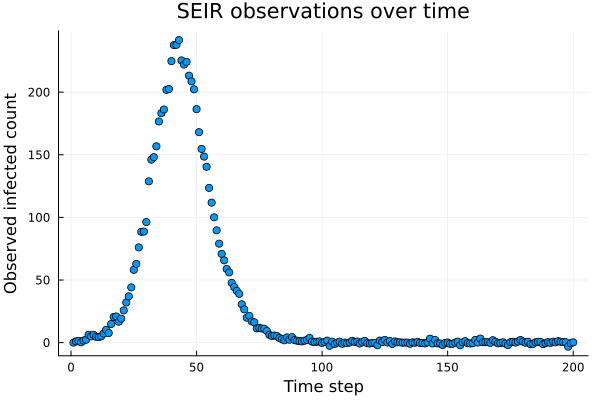

In [4]:
# -------------------------------------------------
# 2. Generate synthetic data with TRUE parameters
# -------------------------------------------------
Random.seed!(124)

T = 200
N = 1_000

true_params = choicemap(
    :beta_var  => 0.6,
    :sigma_var => 0.2,
    :gamma_var => 0.15
)

# true_params = choicemap(
#     :beta_var  => 0.423,
#     :sigma_var => 0.411,
#     :gamma_var => 0.085
# )

trace, _ = generate(seir_model, (T, N), true_params)
observations = get_retval(trace)

# Print the Observations
println("\nObservations:")
for t in 1:T
    println("t=$t: infected=$(observations[t])")
end

# Plot the observations
scatter(
    1:length(observations),
    observations,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)

In [5]:
# -------------------------------------------------
# 3. Particle filter
# -------------------------------------------------
function particle_filter(observations, T, N, n_particles; ess_thresh=0.5)
    obs_choices = [
        choicemap((t => :obs, observations[t]))
        for t in 1:T
    ]

    state = pf_initialize(
        seir_model,
        (1, N),
        obs_choices[1],
        n_particles
    )

    for t in 2:T
        if effective_sample_size(state) < ess_thresh * n_particles
            pf_resample!(state, :residual)

            # Rejuvenate static parameters
            rejuv_sel = select(:beta_var, :sigma_var, :gamma_var)
            pf_rejuvenate!(state, mh, (rejuv_sel,))
        end

        pf_update!(
            state,
            (t, N),
            (UnknownChange(), NoChange()),
            obs_choices[t]
        )
    end

    return state
end

state = particle_filter(observations, T, N, 500)

# -------------------------------------------------
# 4. Posterior estimates
# -------------------------------------------------
beta_posterior_base = mean(state, :beta_var)
sigma_posterior_base = mean(state, :sigma_var)
gamma_posterior_base = mean(state, :gamma_var)

println("True parameters:")
println("β = ", true_params[:beta_var])
println("σ = ", true_params[:sigma_var])
println("γ = ", true_params[:gamma_var])

println("\nPosterior mean estimates:")
println("β̂ = ", round(beta_posterior_base, digits=3))
println("σ̂ = ", round(sigma_posterior_base, digits=3))
println("γ̂ = ", round(gamma_posterior_base, digits=3))

println("\nAbsolute errors:")
println("|β̂ − β| = ", round(abs(beta_posterior_base - true_params[:beta_var]), digits=3))
println("|σ̂ − σ| = ", round(abs(sigma_posterior_base - true_params[:sigma_var]), digits=3))
println("|γ̂ − γ| = ", round(abs(gamma_posterior_base - true_params[:gamma_var]), digits=3))

# -------------------------------------------------
# 5. Recovery diagnostics
# -------------------------------------------------
println("\nRecovery check (within 1 posterior std):")
println("β : ", abs(beta_posterior_base - true_params[:beta_var]) ≤ sqrt(var(state, :beta_var)))
println("σ : ", abs(sigma_posterior_base - true_params[:sigma_var]) ≤ sqrt(var(state, :sigma_var)))
println("γ : ", abs(gamma_posterior_base - true_params[:gamma_var]) ≤ sqrt(var(state, :gamma_var)))

True parameters:
β = 0.6
σ = 0.2
γ = 0.15

Posterior mean estimates:
β̂ = 0.645
σ̂ = 0.559
γ̂ = 0.13

Absolute errors:
|β̂ − β| = 0.045
|σ̂ − σ| = 0.359
|γ̂ − γ| = 0.02

Recovery check (within 1 posterior std):
β : false
σ : false
γ : false


In [6]:
Random.seed!(42)

function guided_seir_filter(observations, T, N; num_particles=250, ess_thresh=0.5)
    particles = Vector{Trace}(undef, num_particles)
    logw = zeros(num_particles)
    
    # Track compartments per particle explicitly to avoid reading flows as states
    S = fill(N - 1, num_particles)
    E = fill(0, num_particles)
    I = fill(1, num_particles)
    R = fill(0, num_particles)
    
    # Initialize particles (for static parameters)
    for i in 1:num_particles
        particles[i], _ = generate(seir_model, (T, N))
    end
    
    for t in 1:T
        println("Time step: $t")
        I_obs = observations[t]
        
        for i in 1:num_particles
            tr = particles[i]
            beta = tr[:beta_var]
            sigma = tr[:sigma_var]
            gamma = tr[:gamma_var]
            
            # Stochastic guided proposal uses current compartment counts
            prob_I = clamp(I_obs / max(E[i], 1), 0.01, 0.99)
            new_I_val = rand(Binomial(E[i], prob_I))
            new_E_val = rand(Binomial(S[i], clamp(beta * I[i] / N, 0.0, 1.0)))
            new_R_val = rand(Binomial(I[i], gamma))
            
            # Update compartments
            S[i] -= new_E_val
            E[i] += new_E_val - new_I_val
            I[i] += new_I_val - new_R_val
            R[i] += new_R_val
            
            # Accumulate log-weight from observation likelihood of current I
            logw[i] += Distributions.logpdf(Normal(I[i], 1.0), I_obs)
        end
        
        # Normalize weights and compute ESS
        maxw = maximum(logw)
        w_norm = exp.(logw .- maxw)
        w_norm ./= sum(w_norm)
        ess = 1 / sum(w_norm .^ 2)
        println("ESS = $ess")
        
        # Resample when degeneracy detected
        if ess < ess_thresh * num_particles
            idx = sample(1:num_particles, Weights(w_norm), num_particles)
            particles = particles[idx]
            S = S[idx]; E = E[idx]; I = I[idx]; R = R[idx]
            logw .= 0.0
            
            # Rejuvenate static parameters β, σ, γ
            for i in 1:num_particles
                tr_new, _ = mh(particles[i], select(:beta_var, :sigma_var, :gamma_var))
                particles[i] = tr_new
            end
        end
    end
    
    return particles, S, E, I, R
end

# -----------------------------
# Run stochastic guided filter
# -----------------------------
T = 200
N = 1_000
particles, S_particles, E_particles, I_particles, R_particles = guided_seir_filter(observations, T, N, num_particles=200)

Time step: 1
ESS = 189.90276523878913
Time step: 2
ESS = 187.93541267532964
Time step: 3
ESS = 163.5330469745184
Time step: 4
ESS = 144.02021389715748
Time step: 5
ESS = 106.14079037755948
Time step: 6
ESS = 67.47630042115242
Time step: 7
ESS = 10.622134303521849
Time step: 8
ESS = 135.26677556651774
Time step: 9
ESS = 73.6562406374602
Time step: 10
ESS = 83.41238019310735
Time step: 11
ESS = 98.37339038238984
Time step: 12
ESS = 137.45650905210687
Time step: 13
ESS = 56.68178388823707
Time step: 14
ESS = 22.40735008635383
Time step: 15
ESS = 87.12324595112915
Time step: 16
ESS = 4.670828342802484
Time step: 17
ESS = 10.13461993955465
Time step: 18
ESS = 77.69936676960191
Time step: 19
ESS = 16.28645001786561
Time step: 20
ESS = 78.84337210765555
Time step: 21
ESS = 18.490611173127164
Time step: 22
ESS = 29.639079152323557
Time step: 23
ESS = 51.68317988425924
Time step: 24
ESS = 24.410418131287635
Time step: 25
ESS = 2.105878307866849
Time step: 26
ESS = 32.945961703568415
Time step: 

(Trace[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##seir_model#277", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:beta_var => Gen.ChoiceOrCallRecord{Float64}(0.27311963446028104, 0.5490745433010757, NaN, true), :gamma_var => Gen.ChoiceOrCallRecord{Float64}(0.15215153134154658, 1.2384143185675622, NaN, true), :sigma_var => Gen.ChoiceOrCallRecord{Float64}(0.08825990126629978, 0.6041267519287654, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(56 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:new_E => Gen.ChoiceOrCallRecord{Int64}(1, -1.5817454235373525, NaN, true), :obs => Gen.ChoiceOrCallRecord{Float64}(1.1354337293729273, -0.9281096807306023, NaN, true), :new_I => Gen.ChoiceOrCallRecord{Int64}(0, -0.36960123592332006, NaN, true), :new_R => Gen.ChoiceOrCallRecord

In [7]:
# -----------------------------
# Posterior estimates
# -----------------------------
beta_posterior_guided = mean([tr[:beta_var] for tr in particles])
sigma_posterior_guided = mean([tr[:sigma_var] for tr in particles])
gamma_posterior_guided = mean([tr[:gamma_var] for tr in particles])

# Print beta_posterior_guided
println([tr[:beta_var] for tr in particles])

println("\nGuided filter posterior means:")
println("β̂ = ", round(beta_posterior_guided, digits=3))
println("σ̂ = ", round(sigma_posterior_guided, digits=3))
println("γ̂ = ", round(gamma_posterior_guided, digits=3))

println("\nPosterior mean estimates:")
println("β̂ = ", round(beta_posterior_base, digits=3))
println("σ̂ = ", round(sigma_posterior_base, digits=3))
println("γ̂ = ", round(gamma_posterior_base, digits=3))

println("\nTrue parameters:")
println("β = ", true_params[:beta_var])
println("σ = ", true_params[:sigma_var])
println("γ = ", true_params[:gamma_var])

[0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.27311963446028104, 0.2731196344

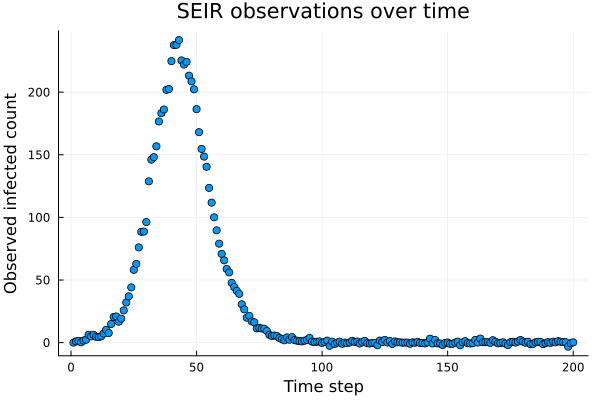

In [8]:
Random.seed!(124)

param = choicemap(
    :beta_var  => true_params[:beta_var],
    :sigma_var => true_params[:sigma_var],
    :gamma_var => true_params[:gamma_var]
)

trace, _ = generate(seir_model, (T, N), param)
observations = get_retval(trace)

# Plot the observations
scatter(
    1:length(observations),
    observations,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)

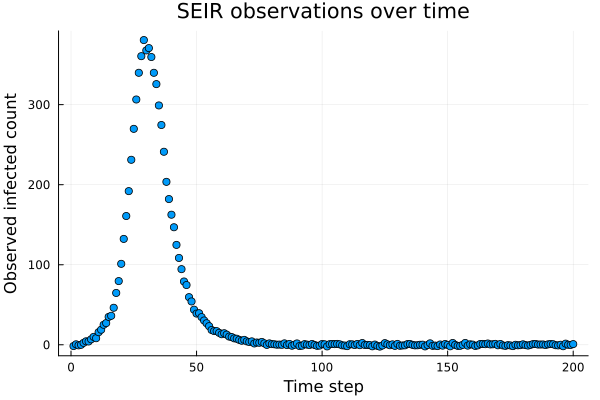

In [9]:
Random.seed!(125)

param = choicemap(
    :beta_var  => beta_posterior_base,
    :sigma_var => sigma_posterior_base,
    :gamma_var => gamma_posterior_base
)

trace, _ = generate(seir_model, (T, N), param)
observations = get_retval(trace)

# Plot the observations
scatter(
    1:length(observations),
    observations,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)

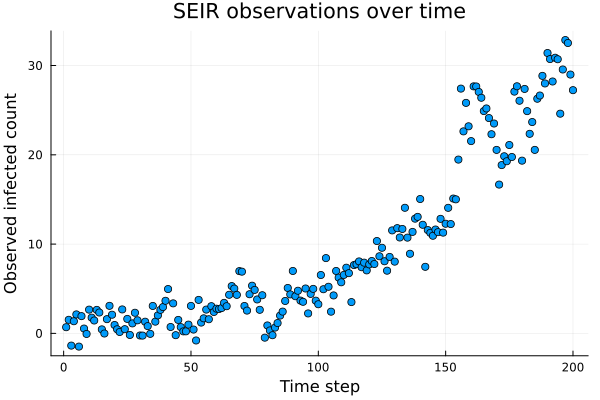

In [10]:
Random.seed!(129)

param = choicemap(
    :beta_var  => beta_posterior_guided,
    :sigma_var => sigma_posterior_guided,
    :gamma_var => gamma_posterior_guided
)

trace, _ = generate(seir_model, (T, N), param)
observations = get_retval(trace)

# Plot the observations
scatter(
    1:length(observations),
    observations,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)

In [11]:
# Set a random seed
Random.seed!(125)

# Turn observations into choicemap format
observations_map = choicemap()
for t in 1:T
    observations_map[(t, :obs)] = observations[t]  # Fixed: correct address format
end

# ---------------- INITIAL TRACE ----------------
(trace, _) = generate(seir_model, (T, N), observations_map)

println("\nInitial parameter guesses:")
println("beta_var  = ", trace[:beta_var])
println("sigma_var = ", trace[:sigma_var])
println("gamma_var = ", trace[:gamma_var])

# ---------------- INFERENCE ----------------
# Select parameters to update
param_sel = select(:beta_var, :sigma_var, :gamma_var)

n_iters = 5000  # number of MH iterations
burn_in = 1000  # discard initial samples
traces = Vector{Any}(undef, n_iters)
current_trace = trace

accepted_count = 0

for i in 1:n_iters
    # Update parameters
    (current_trace, accepted) = mh(current_trace, param_sel)
    if accepted
        accepted_count += 1
    end
    
    traces[i] = current_trace
    
    if i % 1000 == 0
        println("Iteration $i, acceptance rate: ", round(accepted_count/i * 100, digits=2), "%")
    end
end

# ---------------- POSTERIOR SUMMARIES ----------------
# Discard burn-in samples
beta_samples  = [t[:beta_var]  for t in traces[burn_in+1:end]]
sigma_samples = [t[:sigma_var] for t in traces[burn_in+1:end]]
gamma_samples = [t[:gamma_var] for t in traces[burn_in+1:end]]

# Check acceptance rate by looking at unique values
println("\nUnique beta values in chain: ", length(unique(beta_samples)))
println("Chain exploration: ", length(unique(beta_samples)) / length(beta_samples) * 100, "%")

# Print the beta_samples
beta_samples_subset = beta_samples[1:min(10, length(beta_samples))]
println("\nBeta samples (first 10 after burn-in):")
println(beta_samples_subset)

println("\nPosterior means:")
println("beta_var  ≈ ", mean(beta_samples))
println("sigma_var ≈ ", mean(sigma_samples))
println("gamma_var ≈ ", mean(gamma_samples))

println("\nTrue parameters:")
println("beta_var  = ", true_params[:beta_var])
println("sigma_var = ", true_params[:sigma_var])
println("gamma_var = ", true_params[:gamma_var])



Initial parameter guesses:
beta_var  = 0.3416548421785555
sigma_var = 0.3921781939571611
gamma_var = 0.13267989784758674
Iteration 1000, acceptance rate: 0.0%
Iteration 2000, acceptance rate: 0.0%
Iteration 3000, acceptance rate: 0.0%
Iteration 4000, acceptance rate: 0.05%
Iteration 5000, acceptance rate: 0.04%

Unique beta values in chain: 3
Chain exploration: 0.075%

Beta samples (first 10 after burn-in):
[0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555, 0.3416548421785555]

Posterior means:
beta_var  ≈ 0.3511746840926566
sigma_var ≈ 0.4075122823533739
gamma_var ≈ 0.13320271798470992

True parameters:
beta_var  = 0.6
sigma_var = 0.2
gamma_var = 0.15


In [19]:
# Importance sampling for SEIR model
Random.seed!(126)

function importance_sampling_seir(observations, T, N, num_samples=10000)
    # Storage for samples and weights
    samples = Vector{Any}(undef, num_samples)
    log_weights = zeros(num_samples)
    
    # Generate samples from prior and compute importance weights
    for i in 1:num_samples
        # Sample from prior (unconstrained)
        trace, _ = generate(seir_model, (T, N))
        samples[i] = trace
        
        # Compute log likelihood of observations
        log_weight = 0.0
        for t in 1:T
            I_model = trace[t => :obs]
            log_weight += Distributions.logpdf(Normal(I_model, 1.0), observations[t])
        end
        log_weights[i] = log_weight
        
        if i % 1000 == 0
            println("Generated $i samples...")
        end
    end
    
    # Normalize weights
    max_log_weight = maximum(log_weights)
    weights = exp.(log_weights .- max_log_weight)
    weights ./= sum(weights)
    
    # Compute effective sample size
    ess = 1.0 / sum(weights .^ 2)
    println("\nEffective sample size: $ess")
    
    # Compute posterior estimates
    beta_posterior = sum(weights .* [s[:beta_var] for s in samples])
    sigma_posterior = sum(weights .* [s[:sigma_var] for s in samples])
    gamma_posterior = sum(weights .* [s[:gamma_var] for s in samples])

    # Print all the beta_var in sample
    println("\nBeta samples:")
    for i in 1:min(10, num_samples)
        println("Sample $i: β = ", samples[i][:beta_var])
    end

    # Compute the standerd deviations
    beta_std = sqrt(sum(weights .* ([s[:beta_var] - beta_posterior for s in samples] .^ 2)))
    sigma_std = sqrt(sum(weights .* ([s[:sigma_var] - sigma_posterior for s in samples] .^ 2)))
    gamma_std = sqrt(sum(weights .* ([s[:gamma_var] - gamma_posterior for s in samples] .^ 2)))
    
    println("\nImportance sampling posterior means:")
    println("β̂ = ", round(beta_posterior, digits=3))
    println("σ̂ = ", round(sigma_posterior, digits=3))
    println("γ̂ = ", round(gamma_posterior, digits=3))
    println("\nImportance sampling posterior standard deviations:")
    println("σ_β = ", round(beta_std, digits=3))
    println("σ_σ = ", round(sigma_std, digits=3))
    println("σ_γ = ", round(gamma_std, digits=3))
    println("\nTrue parameters:")
    println("β = ", true_params[:beta_var])
    println("σ = ", true_params[:sigma_var])
    println("γ = ", true_params[:gamma_var])
    
    return samples, weights, (beta_posterior, sigma_posterior, gamma_posterior)
end

# Run importance sampling
samples, weights, posterior_means = importance_sampling_seir(observations, T, N, 20000)

Generated 1000 samples...
Generated 2000 samples...
Generated 3000 samples...
Generated 4000 samples...
Generated 5000 samples...
Generated 6000 samples...
Generated 7000 samples...
Generated 8000 samples...
Generated 9000 samples...
Generated 10000 samples...
Generated 11000 samples...
Generated 12000 samples...
Generated 13000 samples...
Generated 14000 samples...
Generated 15000 samples...
Generated 16000 samples...
Generated 17000 samples...
Generated 18000 samples...
Generated 19000 samples...
Generated 20000 samples...

Effective sample size: 1.0

Beta samples:
Sample 1: β = 0.39120448248915557
Sample 2: β = 0.31036487094743925
Sample 3: β = 0.12633315434350745
Sample 4: β = 0.2729119528478685
Sample 5: β = 0.29311521590549483
Sample 6: β = 0.6227518465249092
Sample 7: β = 0.5107415259404195
Sample 8: β = 0.6237849254805506
Sample 9: β = 0.10726105818281326
Sample 10: β = 0.5708554701857869

Importance sampling posterior means:
β̂ = 0.457
σ̂ = 0.071
γ̂ = 0.251

Importance samplin

(Any[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##seir_model#277", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:beta_var => Gen.ChoiceOrCallRecord{Float64}(0.39120448248915557, 0.5538360966287026, NaN, true), :gamma_var => Gen.ChoiceOrCallRecord{Float64}(0.18535286968306502, 1.1561706529702782, NaN, true), :sigma_var => Gen.ChoiceOrCallRecord{Float64}(0.2326876222941435, 0.8836938262015592, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(56 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:new_E => Gen.ChoiceOrCallRecord{Int64}(20, -2.4051731066845248, NaN, true), :obs => Gen.ChoiceOrCallRecord{Float64}(87.84776469475803, -2.626055716801785, NaN, true), :new_I => Gen.ChoiceOrCallRecord{Int64}(17, -2.2885501843116067, NaN, true), :new_R => Gen.ChoiceOrCallRecord{Int

β = 0.46717517611337284
σ = 0.09101698347817017
γ = 0.2673544050506405


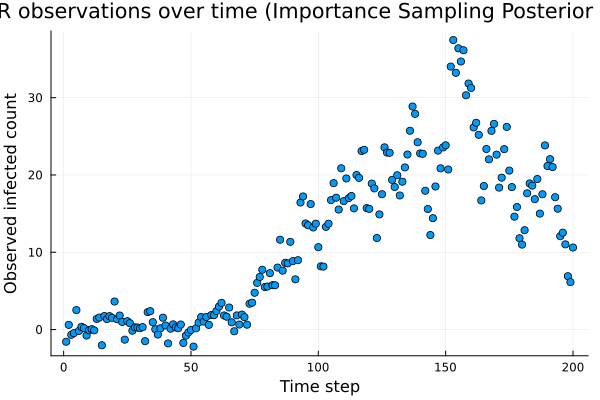

In [18]:
# Plot a trace with the posterior means
beta_post, sigma_post, gamma_post = posterior_means
println("β = ", beta_post)
println("σ = ", sigma_post)
println("γ = ", gamma_post)
Random.seed!(125)
(trace, _) = generate(seir_model, (T, N), choicemap(
    :beta_var  => beta_post,
    :sigma_var => sigma_post,
    :gamma_var => gamma_post
))
observations = get_retval(trace)
# Plot the observations
scatter(
    1:length(observations),
    observations,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time (Importance Sampling Posterior Means)",
    legend = false
)